In [1]:
!pip install easyocr fuzzywuzzy emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 91.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.9/422.9 kB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 912.2/912.2 kB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.8/286.8 kB 21.4 MB/s eta 0:00:00


In [2]:
import easyocr
from PIL import Image
import numpy as np
import torch
import random
from transformers import AutoTokenizer, AutoModel, AutoProcessor, AutoModelForZeroShotImageClassification
import torchvision.transforms as T
from torchvision.transforms.functional import InterpolationMode
import os
import re
import nltk
nltk.download('punkt')
from nltk.metrics.distance import edit_distance
from difflib import SequenceMatcher
import cv2
import torch.nn.functional as F
import emoji
from tabulate import tabulate
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MODEL 1: InternVL
path = "OpenGVLab/InternVL2_5-1B-MPO"
model_int = AutoModel.from_pretrained(
    path,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    low_cpu_mem_usage=True,
    use_flash_attn=True,
    trust_remote_code=True
).eval()

for module in model_int.modules():
    if isinstance(module, torch.nn.Dropout):
        module.p = 0
tokenizer_int = AutoTokenizer.from_pretrained(path, trust_remote_code=True)

# MODEL 2: EasyOCR
reader = easyocr.Reader(['en'], gpu=True)  # Initialize EasyOCR Reader

# MODEL 3: CLIP (Zero-Shot Classifier: used for detecting 'Offensive' and 'Religious' THEMES in the image)
processor_clip = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")
model_clip = AutoModelForZeroShotImageClassification.from_pretrained("openai/clip-vit-base-patch32").to(device)


# Set seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Global seed initialization
set_seed(42)

def build_transform(input_size=448):
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)
    return T.Compose([
        T.Lambda(lambda img: img.convert('RGB')),
        T.Resize((input_size, input_size), interpolation=InterpolationMode.BICUBIC),
        T.ToTensor(),
        T.Normalize(mean=mean, std=std)
    ])
transform = build_transform()

def easyocr_ocr(image):
    image_np = np.array(image)  # Convert to NumPy array
    results = reader.readtext(image_np, detail=1)  # Extract text with bounding box details

    # Clear resources
    del image_np
    torch.cuda.empty_cache()

    if not results:
        return ""

    # Sort results by (top-to-bottom, left-to-right) reading order
    sorted_results = sorted(results, key=lambda x: (x[0][0][1], x[0][0][0]))

    # Extract the text in sorted order
    ordered_text = " ".join([res[1] for res in sorted_results]).strip()

    return ordered_text

def intern(image, prompt, max_tokens):
    pixel_values = transform(image).unsqueeze(0).to(device).to(torch.bfloat16)
    with torch.no_grad():
        response, _ = model_int.chat(
            tokenizer_int,
            pixel_values,
            prompt,
            generation_config={
                "max_new_tokens": max_tokens,
                "do_sample": False,
                "num_beams": 1,
                "temperature": 1.0,
                "top_p": 1.0,
                "repetition_penalty": 1.0,
                "length_penalty": 1.0,
                "pad_token_id": tokenizer_int.pad_token_id  # Explicitly set the pad_token_id
            },
            history=None,
            return_history=True
        )
    # Clean up memory after processing
    del pixel_values  # Explicitly delete pixel_values to free memory
    torch.cuda.empty_cache()  # Clear GPU memory
    #
    return response


def clip(image, labels):
    # Process the image and labels
    processed = processor_clip(
        text=labels,
        images=image,
        padding=True,
        return_tensors="pt"
    ).to(device)

    # Clean up memory after processing
    del image, labels  # Explicitly delete the image and labels
    torch.cuda.empty_cache()  # Clear GPU memory

    return processed

def get_roi(image_path, *roi):
    image = Image.open(image_path).convert('RGB')
    width, height = image.size

    roi_x_start = int(width * roi[0])
    roi_y_start = int(height * roi[1])
    roi_x_end = int(width * roi[2])
    roi_y_end = int(height * roi[3])

    cropped_image = image.crop((roi_x_start, roi_y_start, roi_x_end, roi_y_end))
    return cropped_image



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/3.74k [00:00<?, ?B/s]

configuration_internvl_chat.py:   0%|          | 0.00/3.88k [00:00<?, ?B/s]

configuration_intern_vit.py:   0%|          | 0.00/5.55k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/OpenGVLab/InternVL2_5-1B-MPO:
- configuration_intern_vit.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/OpenGVLab/InternVL2_5-1B-MPO:
- configuration_internvl_chat.py
- configuration_intern_vit.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_internvl_chat.py:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

modeling_intern_vit.py:   0%|          | 0.00/18.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/OpenGVLab/InternVL2_5-1B-MPO:
- modeling_intern_vit.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


conversation.py:   0%|          | 0.00/15.3k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/OpenGVLab/InternVL2_5-1B-MPO:
- conversation.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/OpenGVLab/InternVL2_5-1B-MPO:
- modeling_internvl_chat.py
- modeling_intern_vit.py
- conversation.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


FlashAttention2 is not installed.


model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/129 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/9.02k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/3.38M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/790 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/744 [00:00<?, ?B/s]

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [4]:
# Constants for ROIs
BODY = (0.0, 0.0, 1.0, 1.0)
TAG = (0.05, 0.62, 1.0, 0.65)
DTAG = (0.05, 0.592, 1.0, 0.622)
TNC = (0.02, 0.98, 1.0, 1.0)
CTA = (0.7, 0.652, 0.92, 0.675)
GNC = (0.5, 0.652, 0.93, 0.77)

### TAGLINES ###

# ptag = "Extract all the text from the image that is clear, sharp, and legible. Ignore text that is blurry, faint, distorted, or too small to read. Provide only the clean and clearly visible parts of the text."
ptag = "Extract all the text from the image accurately."
pemo = "Carefully analyze the image to detect emojis. Emojis are graphical icons (e.g., 😀, 🎉, ❤️) and not regular text, symbols, or characters. Examine the image step by step to ensure only graphical emojis are counted. If no emojis are found, respond with 'NUMBER OF EMOJIS: 0'. If emojis are present, count them and provide reasoning before giving the final answer in the format 'NUMBER OF EMOJIS: [count]'. Do not count text or punctuation as emojis."

def clean_text(text):
    return re.sub(r'[^a-zA-Z0-9]', '', text).strip().lower()

def are_strings_similar(str1, str2, max_distance=3, max_length_diff=2): # EasyOCR giving better results that GOT
    if str1 == str2:
        return True
    if abs(len(str1) - len(str2)) > max_length_diff:
        return False
    edit_distance_value = edit_distance(str1, str2)
    # Remove percentage-based adjustment
    return edit_distance_value <= max_distance

def blur_image(image, strength):
    image_np = np.array(image)
    blur_strength = int(strength * 50)  # Scale blur strength (higher values = more blur)
    blur_strength = max(1, blur_strength | 1)  # Ensure odd blur kernel size for GaussianBlur
    blurred_image = cv2.GaussianBlur(image_np, (blur_strength, blur_strength), 0)
    blurred_pil_image = Image.fromarray(blurred_image)
    return blurred_pil_image

def is_blank(text, limit=15):
    """Check if ROI is blank"""
    return len(text) < limit

def is_unreadable_tagline(htag, tag):
    """Check if the tagline is unreadable."""
    clean_htag = clean_text(htag)
    clean_tag = clean_text(tag)
    return not are_strings_similar(clean_htag, clean_tag)

def is_hyperlink_tagline(tag):
    """Check if the tagline contains a hyperlink."""
    substrings = ['www', '.com', 'http']
    return any(sub in tag for sub in substrings)

def is_price_tagline(tag):
    """Check if the tagline contains a price tag."""
    exclude_keywords = ["crore", "thousand", "million", "billion", "trillion"]
    exclude_pattern = r'(₹\.?\s?\d+\s*(lac|lacs|lakh|lakhs|cr|k))|(\brs\.?\s?\d+\s*(lac|lacs|lakh|lakhs|cr|k))|(\$\.?\s?\d+\s*(lac|lacs|lakh|lakhs|cr|k))' # Cr/Lac/...
    price_pattern = r'(₹\.?\s?\d+)|(\brs\.?\s?\d+)|(\$\.?\s?\d+)'
    # Check for exclude keywords
    if any(keyword in tag for keyword in exclude_keywords):
        return False
    # Check if exclude pattern matches
    if re.search(exclude_pattern, tag):
        return False
    # If no exclusions found, check for valid price pattern
    return bool(re.search(price_pattern, tag))

def is_multiple_emoji(emoji):
    """Check if the input contains multiple emojis."""
    words = emoji.split()
    last_word = words[-1]
    return last_word not in ['0', '1']

def is_incomplete_tagline(tag):
    """Check if the tag is incomplete."""
    # Remove emojis and clean whitespace
    tag = emoji.replace_emoji(tag, '')
    tag = tag.strip()

    # Check for ellipsis variations
    if tag.endswith(('...', '..')):
        return True

    tag = re.sub(r'[^a-zA-Z0-9\s]', '', tag)
    words = tag.split()
    last_word = words[-1]

    complete_endings = ['up']
    if last_word in complete_endings:
        return False

    if last_word.isupper(): # WI, ODI, etc.
        return False

    # Complete if ends with number
    if last_word.isdigit():
        return False

    # Incomplete if last word is too short
    if len(last_word) <= 2:
        return True

    last_word = clean_text(last_word)
    # Check for obvious incomplete endings
    incomplete_endings = {
        "and", "but",  "because", "when", "while",
        "although", "though", "unless", "until", "where",
        "since", "however", "therefore", "such", "that",
        "which", "who", "whose", "whom", "wherever", "whenever",
        "whereas"
    }

    if last_word in incomplete_endings:
        return True

    return False

### BODY ###

def string_similarity(a, b):
    """
    Calculate similarity ratio between two strings.
    Returns float between 0 and 1, where 1 means identical strings.
    """
    return SequenceMatcher(None, a.lower(), b.lower()).ratio()

def find_similar_substring(text, keyword, threshold=0.85):
    # Split text into individual words more aggressively
    words = re.findall(r'\b\w+\b', text.lower())
    keyword = keyword.lower()

    # Check each individual word
    for word in words:
        similarity = string_similarity(word, keyword)
        if similarity >= threshold:
            return True

    # Also check consecutive words for multi-word keywords
    keyword_parts = keyword.split()
    if len(keyword_parts) > 1:
        for i in range(len(words) - len(keyword_parts) + 1):
            phrase = ' '.join(words[i:i + len(keyword_parts)])
            similarity = string_similarity(phrase, keyword)
            if similarity >= threshold:
                return True

    return False

def is_risky(body):
    """
    Detects whether an image promotes gambling, gambling websites/apps,
    high-risk trading, or high-risk investments.
    Uses fuzzy matching to account for OCR errors.
    """
    # Keywords and phrases related to risky activities
    risky_keywords = [
        # General gambling terms
        "gamble", "gambling", "casino", "poker", "betting", "bet", "jackpot", "roulette", "blackjack",
        "sports betting", "online casino", "slot machine", "pokies", "lottery", "bingo",

        # Gambling website and app names (Global and India-promoted)
        "stake", "betano", "bet365", "888casino", "paddypower", "williamhill", "ladbrokes", "betfair",
        "unibet", "skybet", "bwin", "coral", "betway", "fanduel", "draftkings", "sportingbet",
        "betfred", "betvictor", "partycasino", "casino.com", "royal panda", "mr green", "jackpot city",
        "playtech", "sbobet", "meccabingo", "fanDuel", "betmobile", "betsson", "10bet", "10cric",
        "pokerstars", "fulltiltpoker", "wsop",

        # Gambling websites and apps promoted or popular in India
        "dream11", "dreamll", "my11circle", "cricbuzz", "fantasy cricket", "sportz exchange", "fun88",
        "funbb", "funbee.com", "funbee", "rummycircle", "pokertiger", "adda52", "khelplay", "winzo",
        "paytm first games", "fanmojo", "betking", "1xbet", "parimatch", "rajapoker",

        # High-risk trading and investment terms
        "forex trading", "trade", "intraday", "binary options", "high risk trading", "cryptocurrency",
        "bitcoin trading", "high risk investment", "margin trading", "forex broker", "investment scheme",
        "broking", "get rich quick", "stocks", "trading signals", "financial markets", "day trading",
        "options trading", "forex signals"
    ]

    # Check each keyword using fuzzy matching
    for keyword in risky_keywords:
        if find_similar_substring(body, keyword):
            return True

    return False

def is_prom_illegal_activity(body):
    """
    Detects the presence of phrases followed by an illegal activity in an image using MiniCPM OCR, allowing for words between the phrase and activity.
    """
    illegal_activities = [
        "hack", "hacking", "cheating", "cheat", "drugs", "drug", "steal", "stealing",
        "phishing", "phish", "piracy", "pirate", "fraud", "smuggling", "smuggle",
        "counterfeiting", "blackmailing", "blackmail", "extortion", "scamming", "scam",
        "identity theft", "illegal trading", "money laundering", "poaching", "poach",
        "trafficking", "illegal arms", "explosives", "bomb", "bombing", "fake documents"
    ]

    phrases = [
        "how to", "learn", "steps to", "guide to", "ways to",
        "tutorial on", "methods for", "process of",
        "tricks for", "shortcuts to", "make"
    ]

    # Check for phrases and activities in sequence
    for phrase in phrases:
        for activity in illegal_activities:
            # Use regex to find phrase followed by activity with any number of words in between
            pattern = rf"{re.escape(phrase)}.*?{re.escape(activity)}"
            if re.search(pattern, body):
                return True

    return False

def is_competitor(body):
    competitor_brands = [
        "motorola", "oppo", "vivo", "htc", "sony", "nokia", "honor", "huawei", "asus", "lg",
        "oneplus", "apple", "micromax", "lenovo", "gionee", "infocus", "lava", "panasonic","intex",
        "blackberry", "xiaomi", "philips", "godrej", "whirlpool", "blue star", "voltas",
        "hitachi", "realme", "poco", "iqoo", "toshiba", "skyworth", "redmi", "nokia", "lava"
    ]
    for brand in competitor_brands:
        if re.search(r'\b' + re.escape(brand) + r'\b', body):
            return True  # Competitor brand detected

    return False  # No competitor brand detected

### THEME ###

def destroy_text_roi(image, *roi_params):
    image_np = np.array(image)

    h, w, _ = image_np.shape
    x1 = int(roi_params[0] * w)
    y1 = int(roi_params[1] * h)
    x2 = int(roi_params[2] * w)
    y2 = int(roi_params[3] * h)

    roi = image_np[y1:y2, x1:x2]

    blurred_roi = cv2.GaussianBlur(roi, (75, 75), 0)
    noise = np.random.randint(0, 50, (blurred_roi.shape[0], blurred_roi.shape[1], 3), dtype=np.uint8)
    noisy_blurred_roi = cv2.add(blurred_roi, noise)
    image_np[y1:y2, x1:x2] = noisy_blurred_roi
    return Image.fromarray(image_np)

def offensive(image):
    image = destroy_text_roi(image, *TAG)

    appr_labels = [
        "Inappropriate Content: Blood, Abuse, political promotion, drugs, alcohol, liquor, intoxicant, cigarette, smoking, cruelty, nudity, animal cruelty, illegal activity, poaching",
        "Appropriate Content: scenery, natural phenomena, sports, food, news, political news, general knowledge, current affairs, miscellaneous item, everyday utility, Ambulance or Medical Symbols"
    ]

    # Generate inputs for the CLIP model
    inputs_appr = clip(image, appr_labels)

    # Ensure that we are working with torch no_grad() context to save memory during inference
    with torch.no_grad():
        outputs_appr = model_clip(**inputs_appr)

    logits_per_image_appr = outputs_appr.logits_per_image
    probs_appr = F.softmax(logits_per_image_appr, dim=1)

    # Extract probabilities
    inappropriate_prob = probs_appr[0][0].item()
    appropriate_prob = probs_appr[0][1].item()

    # Clear any references to large variables to free memory
    del inputs_appr, outputs_appr, logits_per_image_appr, probs_appr
    torch.cuda.empty_cache()  # Free unused GPU memory

    if inappropriate_prob > appropriate_prob:
        return True
    return False

def religious(image):
    religious_labels = [
        "Digital art or sports or news or  miscellaneous activity or miscellaneous item or Person or religious places or diya or deepak or festival or nature or earth imagery or scenery or Medical Plus Sign or Violence or Military or Car",
        "Hindu Deity / OM or AUM or Swastik symbol",
        "Jesus Christ / Christianity Cross"
    ]

    # Generate inputs for the CLIP model
    inputs_religious = clip(image, religious_labels)

    # Ensure that we are working with torch no_grad() context to save memory during inference
    with torch.no_grad():
        outputs_religious = model_clip(**inputs_religious)

    logits_per_image_religious = outputs_religious.logits_per_image
    probs_religious = F.softmax(logits_per_image_religious, dim=1)

    # Find the index with the highest probability
    highest_score_index = torch.argmax(probs_religious, dim=1).item()

    # Clear any references to large variables to free memory
    del inputs_religious, outputs_religious, logits_per_image_religious, probs_religious
    torch.cuda.empty_cache()  # Free unused GPU memory

    if highest_score_index != 0:
        return True, religious_labels[highest_score_index]  # Return the specific religious symbol detected
    return False, None


In [5]:
def image_quality(image_path):
    """
    Check if an image is low resolution or poor quality.
    """
    # Define stricter thresholds for low resolution
    MIN_WIDTH = 720       # Minimum width in pixels
    MIN_HEIGHT = 1600      # Minimum height in pixels
    MIN_PIXEL_COUNT = 1000000  # Minimum total pixel count (width x height)
    PIXEL_VARIANCE_THRESHOLD = 50  # Variance below this indicates low-quality images

    try:
        # Open the image
        image = Image.open(image_path)
        width, height = image.size  # Get width and height
        pixel_count = width * height  # Calculate total pixel count

        # Check resolution thresholds
        if width < MIN_WIDTH or height < MIN_HEIGHT or pixel_count < MIN_PIXEL_COUNT:
            return {"Bad Image Quality": 1}  # Low Quality: Low Resolution

        # Calculate pixel variance for quality check
        grayscale_image = image.convert("L")  # Convert to grayscale
        pixel_array = np.array(grayscale_image)
        variance = np.var(pixel_array)

        # Check pixel variance
        if variance < PIXEL_VARIANCE_THRESHOLD:
            return {"Bad Image Quality": 1}  # Low Quality: Low Pixel Variance

        return {"Bad Image Quality": 0}  # High Quality

    except Exception as e:
        print(f"Error processing image: {e}")
        return {"Bad Image Quality": 1}  # Default to low quality on error


RIB_ROIS = [
    (0.0, 0.61, 0.5, 0.63),  # Top section
    (0.5, 0.61, 1, 0.63),
    (0.0, 0.678, 0.5, 0.698),  # Bottom section
    (0.5, 0.678, 1, 0.698),
    (0.95, 0.63, 1, 0.678),  # Extreme Right section
    (0.05, 0.648, 0.67, 0.658)  # Middle Section (between Tag and Click)
]

def ribbon(image_path):
    image = cv2.imread(image_path)
    h, w = image.shape[:2]
    edge_present = []

    for roi in RIB_ROIS:
        x1, y1, x2, y2 = [int(coord * (w if i % 2 == 0 else h)) for i, coord in enumerate(roi)]
        roi_img = image[y1:y2, x1:x2]
        edges = cv2.Canny(cv2.cvtColor(roi_img, cv2.COLOR_BGR2GRAY), 50, 150)
        edge_present.append(np.any(edges))

    result = all(edge_present[:4]) and not any(edge_present[4:])
    return {"No Ribbon": 0 if result else 1}

def tagline(image_path):
    """Classify the tagline based on its content."""
    results = {
        "Empty/Illegible/Black Tagline": 0,
        "Multiple Taglines": 0,
        "Incomplete Tagline": 0,
        "Hyperlink": 0,
        "Price Tag": 0,
        "Excessive Emojis": 0

    }

    # Get the tagline ROI
    image = get_roi(image_path, *TAG)
    easytag = easyocr_ocr(image).lower().strip()

    # Check if tagline exists
    if is_blank(easytag):
        results["Empty/Illegible/Black Tagline"] = 1
        return results

    Tag = intern(image, ptag, 25).strip()
    tag = Tag.lower()

    # Check readability using blurred image
    himage = blur_image(image, 0.2)
    htag = intern(himage, ptag, 25).lower()

    # Set Tagline to 1 if either missing or illegible
    if is_unreadable_tagline(htag, tag):
        results["Empty/Illegible/Black Tagline"] = 1

    # Check for double tagline
    imagedt = get_roi(image_path, *DTAG)
    dtag = easyocr_ocr(imagedt).strip()
    results["Multiple Taglines"] = 0 if is_blank(dtag) else 1

    # Check for completeness
    results["Incomplete Tagline"] = 1 if is_incomplete_tagline(Tag) else 0

    # Check for hyperlink
    results["Hyperlink"] = 1 if is_hyperlink_tagline(tag) else 0

    # Check for price tag
    results["Price Tag"] = 1 if is_price_tagline(tag) else 0

    # Check for multiple emojis
    emoji = intern(image, pemo, 100)
    results["Excessive Emojis"] = 1 if is_multiple_emoji(emoji) else 0

    return results

def tooMuchText(image_path):
    DRIB = (0.04, 0.625, 1.0, 0.677)
    DUP = (0, 0, 1.0, 0.25)
    DBEL = (0, 0.85, 1.0, 1)
    image = Image.open(image_path).convert('RGB')
    image = destroy_text_roi(image, *DRIB)
    image = destroy_text_roi(image, *DUP)
    image = destroy_text_roi(image, *DBEL)
    bd = easyocr_ocr(image).lower().strip()
    return {"Too Much Text": 1 if len(bd) > 25 else 0}


def theme(image_path):
    """Check theme appropriateness."""
    results = {}
    image = Image.open(image_path).convert('RGB')

    # Check for offensive content
    is_offensive = offensive(image)
    results["Inappropriate Content"] = 1 if offensive(image) else 0

    # Check for religious content
    is_religious, religious_label = religious(image)
    results["Religious Content"] = f"1 [{religious_label}]" if is_religious else "0"

    return results

def body(image_path):
    """Check body content for various criteria."""
    results = {}

    image = Image.open(image_path).convert('RGB')
    bd = intern(image, ptag, 500).lower()
    ocr_substitutions = {'0': 'o', '1': 'l', '!': 'l', '@': 'a', '5': 's', '8': 'b'}

    for char, substitute in ocr_substitutions.items():
        bd = bd.replace(char, substitute)
    bd = ' '.join(bd.split())

    results["High Risk Content"] = 1 if is_risky(bd) else 0
    results["Illegal Content"] = 1 if is_prom_illegal_activity(bd) else 0
    results["Competitor References"] = 1 if is_competitor(bd) else 0

    return results

def cta(image_path):
    """Check CTA validity."""
    image = get_roi(image_path, *CTA)
    cta = intern(image, ptag, 5).strip()

    if '..' in cta or '...' in cta:  # CTA contains ellipsis
        return {"Bad CTA": 1}

    # Check if CTA contains any emoji
    if any(emoji.is_emoji(c) for c in cta):
        return {"Bad CTA": 1}

    cta = cta.strip()
    # Check if CTA is only 1 word
    if len(cta.split()) == 1:  # Split the CTA text by spaces and check word count
        return {"Bad CTA": 1}

    clean_cta = clean_text(cta)  # Clean the CTA text (e.g., lowercase, remove spaces)
    invalid_ctas = ['try', 'view', 'play', 'buynow', 'ordernow', 'paynow']
    if clean_cta in invalid_ctas:  # CTA is invalid
        return {"Bad CTA": 1}

    if len(clean_cta) <= 2 or len(clean_cta) > 12:  # CTA has 2 or fewer letters
        return {"Bad CTA": 1}

    # If none of the above conditions are met, CTA is valid
    return {"Bad CTA": 0}


def tnc(image_path):
    """Check for terms and conditions."""
    image = get_roi(image_path, *TNC)
    tnc = easyocr_ocr(image)
    clean_tnc = clean_text(tnc)

    return {"Terms & Conditions": 0 if is_blank(clean_tnc) else 1}

def gnc(image_path):
    """Check for gestures/coach marks and display the image."""
    pgnc = "Is there a HAND POINTER/EMOJI or a LARGE ARROW or ARROW POINTER? Answer only 'yes' or 'no'."

    image = get_roi(image_path, *GNC)
    gnc = intern(image, pgnc, 900).lower()

    return {"Visual Gesture or Icon": 1 if 'yes' in gnc else 0}

### MULTIPLE IMAGES ###
def classify(image_path):
    """Perform complete classification with detailed results."""
    # Components to check
    components = [
        image_quality,
        ribbon,
        tagline,
        tooMuchText,
        theme,
        body,
        cta,
        tnc,
        gnc
    ]

    # Collect all results
    all_results = {}
    for component in components:
        results = component(image_path)
        all_results.update(results)

    # Calculate final classification
    final_classification = 1 if any(result == 1 for result in all_results.values()) else 0

    # Determine Pass or Fail
    classification_result = "Fail" if final_classification == 1 else "Pass"

    # Prepare the table data
    table_data = []
    labels = [
        "Bad Image Quality", "No Ribbon", "Empty/Illegible/Black Tagline", "Multiple Taglines",
        "Incomplete Tagline", "Hyperlink", "Price Tag", "Excessive Emojis", "Too Much Text",
        "Inappropriate Content", "Religious Content", "High Risk Content",
        "Illegal Content", "Competitor References", "Bad CTA", "Terms & Conditions",
        "Visual Gesture or Icon"
    ]

    # Collect labels responsible for failure
    failure_labels = [label for label in labels if all_results.get(label, 0) == 1]

    for label in labels:
        result = all_results.get(label, 0)  # Default to 0 if the result is not found
        table_data.append([label, result])

    # Format the results as a table
    result_table = tabulate(table_data, headers=["LABEL", "RESULT"], tablefmt="fancy_grid")

    # Return the final classification, result table, and failure labels (if any)
    return classification_result, result_table, failure_labels


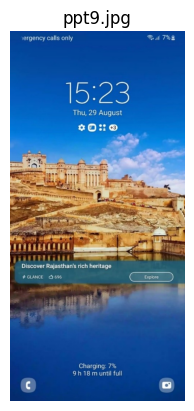

--------------------------------------------------
             CLASSIFICATION: ❌
--------------------------------------------------
╒═══════════════════════════════╤══════════╕
│ LABEL                         │   RESULT │
╞═══════════════════════════════╪══════════╡
│ Bad Image Quality             │        1 │
├───────────────────────────────┼──────────┤
│ No Ribbon                     │        0 │
├───────────────────────────────┼──────────┤
│ Empty/Illegible/Black Tagline │        1 │
├───────────────────────────────┼──────────┤
│ Multiple Taglines             │        0 │
├───────────────────────────────┼──────────┤
│ Incomplete Tagline            │        0 │
├───────────────────────────────┼──────────┤
│ Hyperlink                     │        0 │
├───────────────────────────────┼──────────┤
│ Price Tag                     │        0 │
├───────────────────────────────┼──────────┤
│ Excessive Emojis              │        0 │
├───────────────────────────────┼──────────┤
│ Too Much T

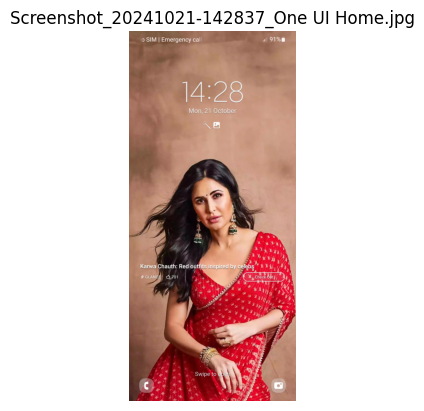

--------------------------------------------------
             CLASSIFICATION: ❌
--------------------------------------------------
╒═══════════════════════════════╤══════════╕
│ LABEL                         │   RESULT │
╞═══════════════════════════════╪══════════╡
│ Bad Image Quality             │        0 │
├───────────────────────────────┼──────────┤
│ No Ribbon                     │        1 │
├───────────────────────────────┼──────────┤
│ Empty/Illegible/Black Tagline │        0 │
├───────────────────────────────┼──────────┤
│ Multiple Taglines             │        0 │
├───────────────────────────────┼──────────┤
│ Incomplete Tagline            │        0 │
├───────────────────────────────┼──────────┤
│ Hyperlink                     │        0 │
├───────────────────────────────┼──────────┤
│ Price Tag                     │        0 │
├───────────────────────────────┼──────────┤
│ Excessive Emojis              │        0 │
├───────────────────────────────┼──────────┤
│ Too Much T

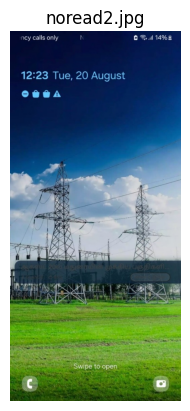

--------------------------------------------------
             CLASSIFICATION: ❌
--------------------------------------------------
╒═══════════════════════════════╤══════════╕
│ LABEL                         │   RESULT │
╞═══════════════════════════════╪══════════╡
│ Bad Image Quality             │        1 │
├───────────────────────────────┼──────────┤
│ No Ribbon                     │        0 │
├───────────────────────────────┼──────────┤
│ Empty/Illegible/Black Tagline │        1 │
├───────────────────────────────┼──────────┤
│ Multiple Taglines             │        0 │
├───────────────────────────────┼──────────┤
│ Incomplete Tagline            │        0 │
├───────────────────────────────┼──────────┤
│ Hyperlink                     │        0 │
├───────────────────────────────┼──────────┤
│ Price Tag                     │        0 │
├───────────────────────────────┼──────────┤
│ Excessive Emojis              │        0 │
├───────────────────────────────┼──────────┤
│ Too Much T

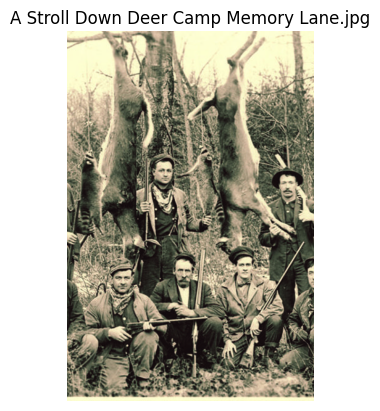

--------------------------------------------------
             CLASSIFICATION: ❌
--------------------------------------------------
╒═══════════════════════════════╤══════════╕
│ LABEL                         │   RESULT │
╞═══════════════════════════════╪══════════╡
│ Bad Image Quality             │        1 │
├───────────────────────────────┼──────────┤
│ No Ribbon                     │        1 │
├───────────────────────────────┼──────────┤
│ Empty/Illegible/Black Tagline │        1 │
├───────────────────────────────┼──────────┤
│ Multiple Taglines             │        0 │
├───────────────────────────────┼──────────┤
│ Incomplete Tagline            │        0 │
├───────────────────────────────┼──────────┤
│ Hyperlink                     │        0 │
├───────────────────────────────┼──────────┤
│ Price Tag                     │        0 │
├───────────────────────────────┼──────────┤
│ Excessive Emojis              │        0 │
├───────────────────────────────┼──────────┤
│ Too Much T

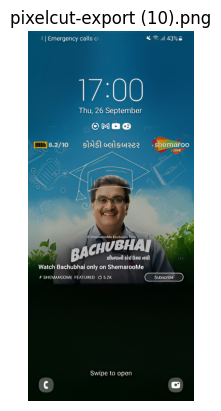

--------------------------------------------------
             CLASSIFICATION: ❌
--------------------------------------------------
╒═══════════════════════════════╤══════════╕
│ LABEL                         │   RESULT │
╞═══════════════════════════════╪══════════╡
│ Bad Image Quality             │        1 │
├───────────────────────────────┼──────────┤
│ No Ribbon                     │        1 │
├───────────────────────────────┼──────────┤
│ Empty/Illegible/Black Tagline │        1 │
├───────────────────────────────┼──────────┤
│ Multiple Taglines             │        1 │
├───────────────────────────────┼──────────┤
│ Incomplete Tagline            │        0 │
├───────────────────────────────┼──────────┤
│ Hyperlink                     │        0 │
├───────────────────────────────┼──────────┤
│ Price Tag                     │        0 │
├───────────────────────────────┼──────────┤
│ Excessive Emojis              │        0 │
├───────────────────────────────┼──────────┤
│ Too Much T

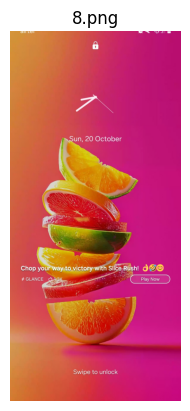

--------------------------------------------------
             CLASSIFICATION: ❌
--------------------------------------------------
╒═══════════════════════════════╤══════════╕
│ LABEL                         │   RESULT │
╞═══════════════════════════════╪══════════╡
│ Bad Image Quality             │        0 │
├───────────────────────────────┼──────────┤
│ No Ribbon                     │        1 │
├───────────────────────────────┼──────────┤
│ Empty/Illegible/Black Tagline │        0 │
├───────────────────────────────┼──────────┤
│ Multiple Taglines             │        0 │
├───────────────────────────────┼──────────┤
│ Incomplete Tagline            │        0 │
├───────────────────────────────┼──────────┤
│ Hyperlink                     │        0 │
├───────────────────────────────┼──────────┤
│ Price Tag                     │        0 │
├───────────────────────────────┼──────────┤
│ Excessive Emojis              │        1 │
├───────────────────────────────┼──────────┤
│ Too Much T

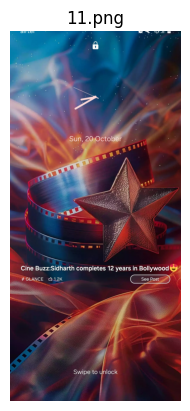

--------------------------------------------------
             CLASSIFICATION: ❌
--------------------------------------------------
╒═══════════════════════════════╤══════════╕
│ LABEL                         │   RESULT │
╞═══════════════════════════════╪══════════╡
│ Bad Image Quality             │        0 │
├───────────────────────────────┼──────────┤
│ No Ribbon                     │        1 │
├───────────────────────────────┼──────────┤
│ Empty/Illegible/Black Tagline │        0 │
├───────────────────────────────┼──────────┤
│ Multiple Taglines             │        0 │
├───────────────────────────────┼──────────┤
│ Incomplete Tagline            │        0 │
├───────────────────────────────┼──────────┤
│ Hyperlink                     │        0 │
├───────────────────────────────┼──────────┤
│ Price Tag                     │        0 │
├───────────────────────────────┼──────────┤
│ Excessive Emojis              │        0 │
├───────────────────────────────┼──────────┤
│ Too Much T

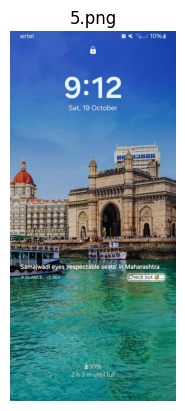

--------------------------------------------------
             CLASSIFICATION: ❌
--------------------------------------------------
╒═══════════════════════════════╤══════════╕
│ LABEL                         │   RESULT │
╞═══════════════════════════════╪══════════╡
│ Bad Image Quality             │        0 │
├───────────────────────────────┼──────────┤
│ No Ribbon                     │        1 │
├───────────────────────────────┼──────────┤
│ Empty/Illegible/Black Tagline │        0 │
├───────────────────────────────┼──────────┤
│ Multiple Taglines             │        0 │
├───────────────────────────────┼──────────┤
│ Incomplete Tagline            │        0 │
├───────────────────────────────┼──────────┤
│ Hyperlink                     │        0 │
├───────────────────────────────┼──────────┤
│ Price Tag                     │        0 │
├───────────────────────────────┼──────────┤
│ Excessive Emojis              │        0 │
├───────────────────────────────┼──────────┤
│ Too Much T

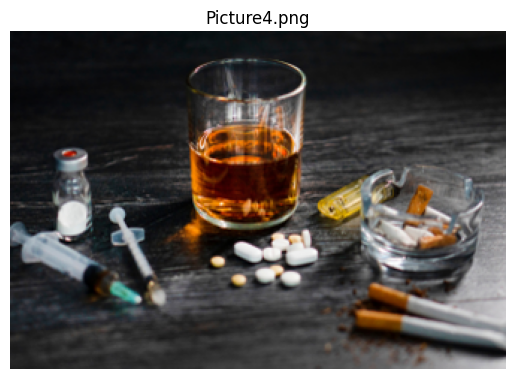

--------------------------------------------------
             CLASSIFICATION: ❌
--------------------------------------------------
╒═══════════════════════════════╤══════════╕
│ LABEL                         │   RESULT │
╞═══════════════════════════════╪══════════╡
│ Bad Image Quality             │        1 │
├───────────────────────────────┼──────────┤
│ No Ribbon                     │        1 │
├───────────────────────────────┼──────────┤
│ Empty/Illegible/Black Tagline │        1 │
├───────────────────────────────┼──────────┤
│ Multiple Taglines             │        0 │
├───────────────────────────────┼──────────┤
│ Incomplete Tagline            │        0 │
├───────────────────────────────┼──────────┤
│ Hyperlink                     │        0 │
├───────────────────────────────┼──────────┤
│ Price Tag                     │        0 │
├───────────────────────────────┼──────────┤
│ Excessive Emojis              │        0 │
├───────────────────────────────┼──────────┤
│ Too Much T

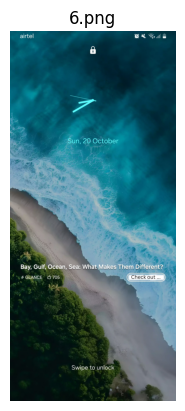

--------------------------------------------------
             CLASSIFICATION: ❌
--------------------------------------------------
╒═══════════════════════════════╤══════════╕
│ LABEL                         │   RESULT │
╞═══════════════════════════════╪══════════╡
│ Bad Image Quality             │        0 │
├───────────────────────────────┼──────────┤
│ No Ribbon                     │        1 │
├───────────────────────────────┼──────────┤
│ Empty/Illegible/Black Tagline │        0 │
├───────────────────────────────┼──────────┤
│ Multiple Taglines             │        0 │
├───────────────────────────────┼──────────┤
│ Incomplete Tagline            │        0 │
├───────────────────────────────┼──────────┤
│ Hyperlink                     │        0 │
├───────────────────────────────┼──────────┤
│ Price Tag                     │        0 │
├───────────────────────────────┼──────────┤
│ Excessive Emojis              │        0 │
├───────────────────────────────┼──────────┤
│ Too Much T

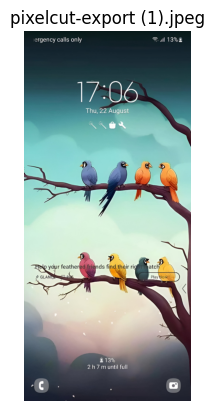

--------------------------------------------------
             CLASSIFICATION: ❌
--------------------------------------------------
╒═══════════════════════════════╤══════════╕
│ LABEL                         │   RESULT │
╞═══════════════════════════════╪══════════╡
│ Bad Image Quality             │        0 │
├───────────────────────────────┼──────────┤
│ No Ribbon                     │        1 │
├───────────────────────────────┼──────────┤
│ Empty/Illegible/Black Tagline │        1 │
├───────────────────────────────┼──────────┤
│ Multiple Taglines             │        0 │
├───────────────────────────────┼──────────┤
│ Incomplete Tagline            │        0 │
├───────────────────────────────┼──────────┤
│ Hyperlink                     │        0 │
├───────────────────────────────┼──────────┤
│ Price Tag                     │        0 │
├───────────────────────────────┼──────────┤
│ Excessive Emojis              │        0 │
├───────────────────────────────┼──────────┤
│ Too Much T

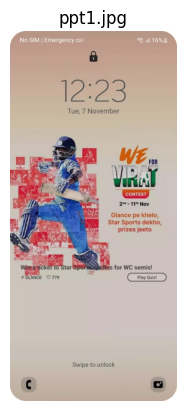

--------------------------------------------------
             CLASSIFICATION: ❌
--------------------------------------------------
╒═══════════════════════════════╤══════════╕
│ LABEL                         │   RESULT │
╞═══════════════════════════════╪══════════╡
│ Bad Image Quality             │        1 │
├───────────────────────────────┼──────────┤
│ No Ribbon                     │        1 │
├───────────────────────────────┼──────────┤
│ Empty/Illegible/Black Tagline │        1 │
├───────────────────────────────┼──────────┤
│ Multiple Taglines             │        0 │
├───────────────────────────────┼──────────┤
│ Incomplete Tagline            │        0 │
├───────────────────────────────┼──────────┤
│ Hyperlink                     │        0 │
├───────────────────────────────┼──────────┤
│ Price Tag                     │        0 │
├───────────────────────────────┼──────────┤
│ Excessive Emojis              │        0 │
├───────────────────────────────┼──────────┤
│ Too Much T

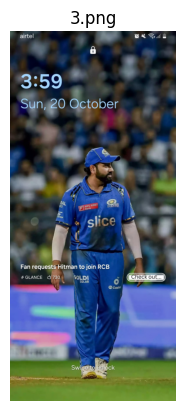

--------------------------------------------------
             CLASSIFICATION: ❌
--------------------------------------------------
╒═══════════════════════════════╤══════════╕
│ LABEL                         │   RESULT │
╞═══════════════════════════════╪══════════╡
│ Bad Image Quality             │        0 │
├───────────────────────────────┼──────────┤
│ No Ribbon                     │        1 │
├───────────────────────────────┼──────────┤
│ Empty/Illegible/Black Tagline │        0 │
├───────────────────────────────┼──────────┤
│ Multiple Taglines             │        0 │
├───────────────────────────────┼──────────┤
│ Incomplete Tagline            │        0 │
├───────────────────────────────┼──────────┤
│ Hyperlink                     │        0 │
├───────────────────────────────┼──────────┤
│ Price Tag                     │        0 │
├───────────────────────────────┼──────────┤
│ Excessive Emojis              │        0 │
├───────────────────────────────┼──────────┤
│ Too Much T

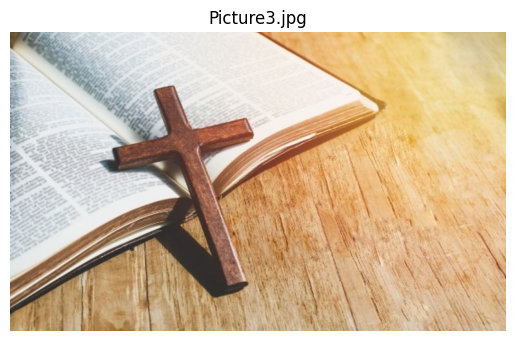

--------------------------------------------------
             CLASSIFICATION: ❌
--------------------------------------------------
╒═══════════════════════════════╤═══════════════════════════════════════╕
│ LABEL                         │ RESULT                                │
╞═══════════════════════════════╪═══════════════════════════════════════╡
│ Bad Image Quality             │ 1                                     │
├───────────────────────────────┼───────────────────────────────────────┤
│ No Ribbon                     │ 1                                     │
├───────────────────────────────┼───────────────────────────────────────┤
│ Empty/Illegible/Black Tagline │ 1                                     │
├───────────────────────────────┼───────────────────────────────────────┤
│ Multiple Taglines             │ 0                                     │
├───────────────────────────────┼───────────────────────────────────────┤
│ Incomplete Tagline            │ 0                  

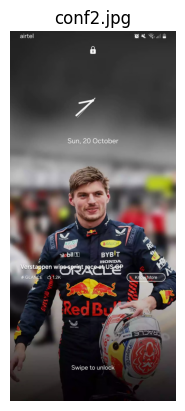

--------------------------------------------------
             CLASSIFICATION: ❌
--------------------------------------------------
╒═══════════════════════════════╤══════════╕
│ LABEL                         │   RESULT │
╞═══════════════════════════════╪══════════╡
│ Bad Image Quality             │        0 │
├───────────────────────────────┼──────────┤
│ No Ribbon                     │        1 │
├───────────────────────────────┼──────────┤
│ Empty/Illegible/Black Tagline │        0 │
├───────────────────────────────┼──────────┤
│ Multiple Taglines             │        0 │
├───────────────────────────────┼──────────┤
│ Incomplete Tagline            │        0 │
├───────────────────────────────┼──────────┤
│ Hyperlink                     │        0 │
├───────────────────────────────┼──────────┤
│ Price Tag                     │        0 │
├───────────────────────────────┼──────────┤
│ Excessive Emojis              │        0 │
├───────────────────────────────┼──────────┤
│ Too Much T

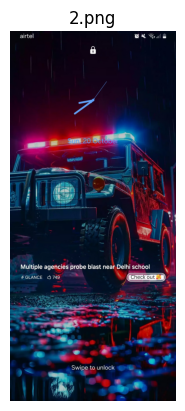

--------------------------------------------------
             CLASSIFICATION: ❌
--------------------------------------------------
╒═══════════════════════════════╤══════════╕
│ LABEL                         │   RESULT │
╞═══════════════════════════════╪══════════╡
│ Bad Image Quality             │        0 │
├───────────────────────────────┼──────────┤
│ No Ribbon                     │        1 │
├───────────────────────────────┼──────────┤
│ Empty/Illegible/Black Tagline │        0 │
├───────────────────────────────┼──────────┤
│ Multiple Taglines             │        0 │
├───────────────────────────────┼──────────┤
│ Incomplete Tagline            │        0 │
├───────────────────────────────┼──────────┤
│ Hyperlink                     │        0 │
├───────────────────────────────┼──────────┤
│ Price Tag                     │        0 │
├───────────────────────────────┼──────────┤
│ Excessive Emojis              │        0 │
├───────────────────────────────┼──────────┤
│ Too Much T

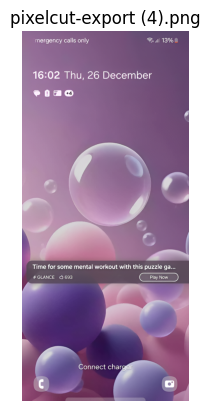

--------------------------------------------------
             CLASSIFICATION: ❌
--------------------------------------------------
╒═══════════════════════════════╤══════════╕
│ LABEL                         │   RESULT │
╞═══════════════════════════════╪══════════╡
│ Bad Image Quality             │        1 │
├───────────────────────────────┼──────────┤
│ No Ribbon                     │        0 │
├───────────────────────────────┼──────────┤
│ Empty/Illegible/Black Tagline │        0 │
├───────────────────────────────┼──────────┤
│ Multiple Taglines             │        0 │
├───────────────────────────────┼──────────┤
│ Incomplete Tagline            │        1 │
├───────────────────────────────┼──────────┤
│ Hyperlink                     │        0 │
├───────────────────────────────┼──────────┤
│ Price Tag                     │        0 │
├───────────────────────────────┼──────────┤
│ Excessive Emojis              │        0 │
├───────────────────────────────┼──────────┤
│ Too Much T

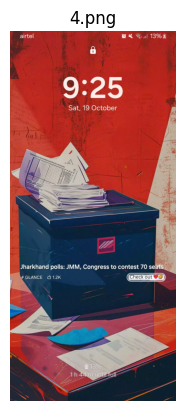

--------------------------------------------------
             CLASSIFICATION: ❌
--------------------------------------------------
╒═══════════════════════════════╤══════════╕
│ LABEL                         │   RESULT │
╞═══════════════════════════════╪══════════╡
│ Bad Image Quality             │        0 │
├───────────────────────────────┼──────────┤
│ No Ribbon                     │        1 │
├───────────────────────────────┼──────────┤
│ Empty/Illegible/Black Tagline │        0 │
├───────────────────────────────┼──────────┤
│ Multiple Taglines             │        0 │
├───────────────────────────────┼──────────┤
│ Incomplete Tagline            │        0 │
├───────────────────────────────┼──────────┤
│ Hyperlink                     │        0 │
├───────────────────────────────┼──────────┤
│ Price Tag                     │        0 │
├───────────────────────────────┼──────────┤
│ Excessive Emojis              │        0 │
├───────────────────────────────┼──────────┤
│ Too Much T

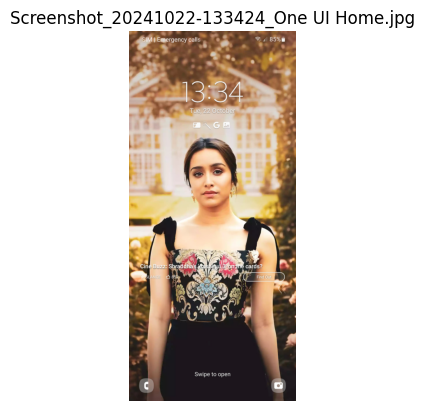

--------------------------------------------------
             CLASSIFICATION: ❌
--------------------------------------------------
╒═══════════════════════════════╤══════════╕
│ LABEL                         │   RESULT │
╞═══════════════════════════════╪══════════╡
│ Bad Image Quality             │        0 │
├───────────────────────────────┼──────────┤
│ No Ribbon                     │        1 │
├───────────────────────────────┼──────────┤
│ Empty/Illegible/Black Tagline │        1 │
├───────────────────────────────┼──────────┤
│ Multiple Taglines             │        0 │
├───────────────────────────────┼──────────┤
│ Incomplete Tagline            │        0 │
├───────────────────────────────┼──────────┤
│ Hyperlink                     │        0 │
├───────────────────────────────┼──────────┤
│ Price Tag                     │        0 │
├───────────────────────────────┼──────────┤
│ Excessive Emojis              │        0 │
├───────────────────────────────┼──────────┤
│ Too Much T

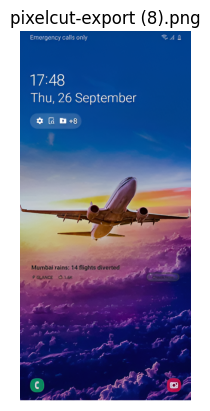

--------------------------------------------------
             CLASSIFICATION: ❌
--------------------------------------------------
╒═══════════════════════════════╤══════════╕
│ LABEL                         │   RESULT │
╞═══════════════════════════════╪══════════╡
│ Bad Image Quality             │        1 │
├───────────────────────────────┼──────────┤
│ No Ribbon                     │        1 │
├───────────────────────────────┼──────────┤
│ Empty/Illegible/Black Tagline │        1 │
├───────────────────────────────┼──────────┤
│ Multiple Taglines             │        0 │
├───────────────────────────────┼──────────┤
│ Incomplete Tagline            │        0 │
├───────────────────────────────┼──────────┤
│ Hyperlink                     │        0 │
├───────────────────────────────┼──────────┤
│ Price Tag                     │        0 │
├───────────────────────────────┼──────────┤
│ Excessive Emojis              │        0 │
├───────────────────────────────┼──────────┤
│ Too Much T

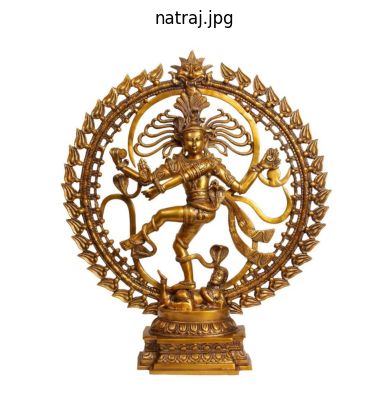

--------------------------------------------------
             CLASSIFICATION: ❌
--------------------------------------------------
╒═══════════════════════════════╤═══════════════════════════════════════════════╕
│ LABEL                         │ RESULT                                        │
╞═══════════════════════════════╪═══════════════════════════════════════════════╡
│ Bad Image Quality             │ 1                                             │
├───────────────────────────────┼───────────────────────────────────────────────┤
│ No Ribbon                     │ 1                                             │
├───────────────────────────────┼───────────────────────────────────────────────┤
│ Empty/Illegible/Black Tagline │ 1                                             │
├───────────────────────────────┼───────────────────────────────────────────────┤
│ Multiple Taglines             │ 0                                             │
├───────────────────────────────┼──────────────

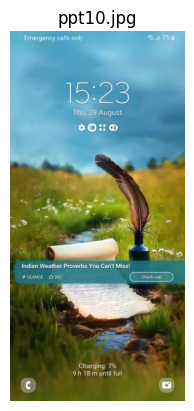

--------------------------------------------------
             CLASSIFICATION: ❌
--------------------------------------------------
╒═══════════════════════════════╤══════════╕
│ LABEL                         │   RESULT │
╞═══════════════════════════════╪══════════╡
│ Bad Image Quality             │        1 │
├───────────────────────────────┼──────────┤
│ No Ribbon                     │        0 │
├───────────────────────────────┼──────────┤
│ Empty/Illegible/Black Tagline │        1 │
├───────────────────────────────┼──────────┤
│ Multiple Taglines             │        0 │
├───────────────────────────────┼──────────┤
│ Incomplete Tagline            │        0 │
├───────────────────────────────┼──────────┤
│ Hyperlink                     │        0 │
├───────────────────────────────┼──────────┤
│ Price Tag                     │        0 │
├───────────────────────────────┼──────────┤
│ Excessive Emojis              │        0 │
├───────────────────────────────┼──────────┤
│ Too Much T

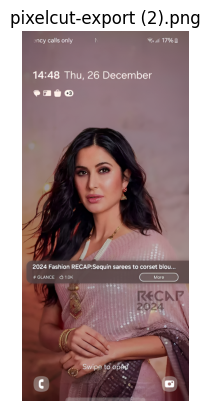

--------------------------------------------------
             CLASSIFICATION: ❌
--------------------------------------------------
╒═══════════════════════════════╤══════════╕
│ LABEL                         │   RESULT │
╞═══════════════════════════════╪══════════╡
│ Bad Image Quality             │        1 │
├───────────────────────────────┼──────────┤
│ No Ribbon                     │        0 │
├───────────────────────────────┼──────────┤
│ Empty/Illegible/Black Tagline │        1 │
├───────────────────────────────┼──────────┤
│ Multiple Taglines             │        0 │
├───────────────────────────────┼──────────┤
│ Incomplete Tagline            │        1 │
├───────────────────────────────┼──────────┤
│ Hyperlink                     │        0 │
├───────────────────────────────┼──────────┤
│ Price Tag                     │        0 │
├───────────────────────────────┼──────────┤
│ Excessive Emojis              │        0 │
├───────────────────────────────┼──────────┤
│ Too Much T

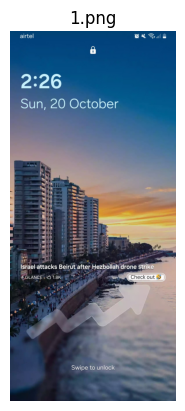

--------------------------------------------------
             CLASSIFICATION: ❌
--------------------------------------------------
╒═══════════════════════════════╤══════════╕
│ LABEL                         │   RESULT │
╞═══════════════════════════════╪══════════╡
│ Bad Image Quality             │        0 │
├───────────────────────────────┼──────────┤
│ No Ribbon                     │        1 │
├───────────────────────────────┼──────────┤
│ Empty/Illegible/Black Tagline │        0 │
├───────────────────────────────┼──────────┤
│ Multiple Taglines             │        0 │
├───────────────────────────────┼──────────┤
│ Incomplete Tagline            │        0 │
├───────────────────────────────┼──────────┤
│ Hyperlink                     │        0 │
├───────────────────────────────┼──────────┤
│ Price Tag                     │        0 │
├───────────────────────────────┼──────────┤
│ Excessive Emojis              │        0 │
├───────────────────────────────┼──────────┤
│ Too Much T

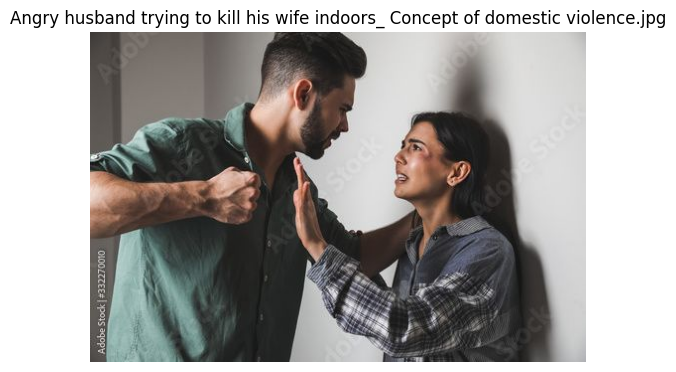

--------------------------------------------------
             CLASSIFICATION: ❌
--------------------------------------------------
╒═══════════════════════════════╤══════════╕
│ LABEL                         │   RESULT │
╞═══════════════════════════════╪══════════╡
│ Bad Image Quality             │        1 │
├───────────────────────────────┼──────────┤
│ No Ribbon                     │        1 │
├───────────────────────────────┼──────────┤
│ Empty/Illegible/Black Tagline │        1 │
├───────────────────────────────┼──────────┤
│ Multiple Taglines             │        0 │
├───────────────────────────────┼──────────┤
│ Incomplete Tagline            │        0 │
├───────────────────────────────┼──────────┤
│ Hyperlink                     │        0 │
├───────────────────────────────┼──────────┤
│ Price Tag                     │        0 │
├───────────────────────────────┼──────────┤
│ Excessive Emojis              │        0 │
├───────────────────────────────┼──────────┤
│ Too Much T

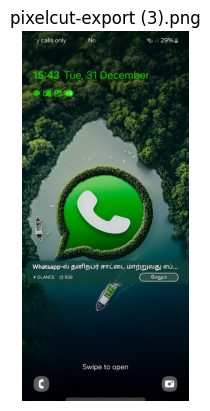

--------------------------------------------------
             CLASSIFICATION: ❌
--------------------------------------------------
╒═══════════════════════════════╤══════════╕
│ LABEL                         │   RESULT │
╞═══════════════════════════════╪══════════╡
│ Bad Image Quality             │        1 │
├───────────────────────────────┼──────────┤
│ No Ribbon                     │        0 │
├───────────────────────────────┼──────────┤
│ Empty/Illegible/Black Tagline │        0 │
├───────────────────────────────┼──────────┤
│ Multiple Taglines             │        0 │
├───────────────────────────────┼──────────┤
│ Incomplete Tagline            │        0 │
├───────────────────────────────┼──────────┤
│ Hyperlink                     │        0 │
├───────────────────────────────┼──────────┤
│ Price Tag                     │        0 │
├───────────────────────────────┼──────────┤
│ Excessive Emojis              │        0 │
├───────────────────────────────┼──────────┤
│ Too Much T

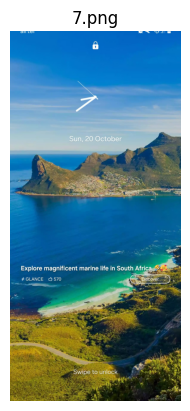

--------------------------------------------------
             CLASSIFICATION: ❌
--------------------------------------------------
╒═══════════════════════════════╤══════════╕
│ LABEL                         │   RESULT │
╞═══════════════════════════════╪══════════╡
│ Bad Image Quality             │        0 │
├───────────────────────────────┼──────────┤
│ No Ribbon                     │        1 │
├───────────────────────────────┼──────────┤
│ Empty/Illegible/Black Tagline │        0 │
├───────────────────────────────┼──────────┤
│ Multiple Taglines             │        0 │
├───────────────────────────────┼──────────┤
│ Incomplete Tagline            │        0 │
├───────────────────────────────┼──────────┤
│ Hyperlink                     │        0 │
├───────────────────────────────┼──────────┤
│ Price Tag                     │        0 │
├───────────────────────────────┼──────────┤
│ Excessive Emojis              │        1 │
├───────────────────────────────┼──────────┤
│ Too Much T

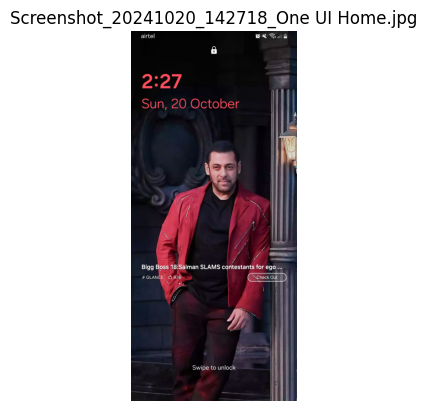

--------------------------------------------------
             CLASSIFICATION: ❌
--------------------------------------------------
╒═══════════════════════════════╤══════════╕
│ LABEL                         │   RESULT │
╞═══════════════════════════════╪══════════╡
│ Bad Image Quality             │        0 │
├───────────────────────────────┼──────────┤
│ No Ribbon                     │        1 │
├───────────────────────────────┼──────────┤
│ Empty/Illegible/Black Tagline │        0 │
├───────────────────────────────┼──────────┤
│ Multiple Taglines             │        0 │
├───────────────────────────────┼──────────┤
│ Incomplete Tagline            │        1 │
├───────────────────────────────┼──────────┤
│ Hyperlink                     │        0 │
├───────────────────────────────┼──────────┤
│ Price Tag                     │        0 │
├───────────────────────────────┼──────────┤
│ Excessive Emojis              │        0 │
├───────────────────────────────┼──────────┤
│ Too Much T

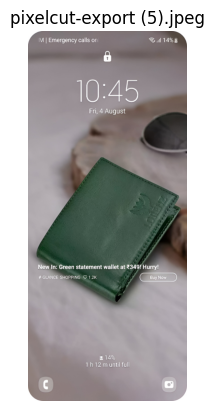

--------------------------------------------------
             CLASSIFICATION: ❌
--------------------------------------------------
╒═══════════════════════════════╤══════════╕
│ LABEL                         │   RESULT │
╞═══════════════════════════════╪══════════╡
│ Bad Image Quality             │        0 │
├───────────────────────────────┼──────────┤
│ No Ribbon                     │        1 │
├───────────────────────────────┼──────────┤
│ Empty/Illegible/Black Tagline │        0 │
├───────────────────────────────┼──────────┤
│ Multiple Taglines             │        0 │
├───────────────────────────────┼──────────┤
│ Incomplete Tagline            │        0 │
├───────────────────────────────┼──────────┤
│ Hyperlink                     │        0 │
├───────────────────────────────┼──────────┤
│ Price Tag                     │        1 │
├───────────────────────────────┼──────────┤
│ Excessive Emojis              │        0 │
├───────────────────────────────┼──────────┤
│ Too Much T

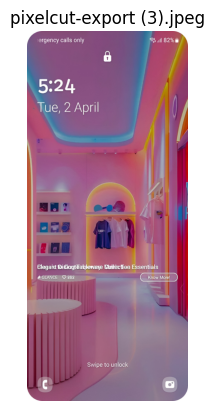

--------------------------------------------------
             CLASSIFICATION: ❌
--------------------------------------------------
╒═══════════════════════════════╤══════════╕
│ LABEL                         │   RESULT │
╞═══════════════════════════════╪══════════╡
│ Bad Image Quality             │        0 │
├───────────────────────────────┼──────────┤
│ No Ribbon                     │        1 │
├───────────────────────────────┼──────────┤
│ Empty/Illegible/Black Tagline │        1 │
├───────────────────────────────┼──────────┤
│ Multiple Taglines             │        0 │
├───────────────────────────────┼──────────┤
│ Incomplete Tagline            │        0 │
├───────────────────────────────┼──────────┤
│ Hyperlink                     │        0 │
├───────────────────────────────┼──────────┤
│ Price Tag                     │        0 │
├───────────────────────────────┼──────────┤
│ Excessive Emojis              │        0 │
├───────────────────────────────┼──────────┤
│ Too Much T

In [19]:
### MULTIPLE IMAGES ###

# Directory containing the images
image_directory = "/content/"  # Replace with your image folder path

# Iterate through all images in the directory
for filename in os.listdir(image_directory):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(image_directory, filename)

        try:
            # Open and display the image
            img = Image.open(image_path)
            plt.imshow(img)
            plt.axis('off')
            plt.title(filename)
            plt.show()

            # Run tagline classification
            classification_result, result_table, failure_labels = classify(image_path)

            print("-" * 50)
            # Print classification result as emoji
            if classification_result  == 'Pass':
                print("             CLASSIFICATION: ✅")
            else:
                print("             CLASSIFICATION: ❌")
            print("-" * 50)

            # Print the result table
            print(result_table)
            print("-" * 50)
            print("-" * 50)
            print()

        except Exception as e:
            print(f"Error processing {filename}: {e}")


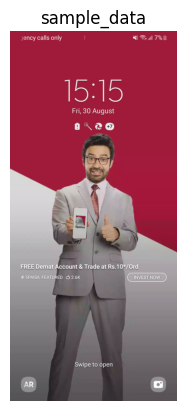

--------------------------------------------------
             CLASSIFICATION: ❌
--------------------------------------------------
╒═══════════════════════════════╤══════════╕
│ LABEL                         │   RESULT │
╞═══════════════════════════════╪══════════╡
│ Bad Image Quality             │        0 │
├───────────────────────────────┼──────────┤
│ No Ribbon                     │        1 │
├───────────────────────────────┼──────────┤
│ Empty/Illegible/Black Tagline │        0 │
├───────────────────────────────┼──────────┤
│ Multiple Taglines             │        0 │
├───────────────────────────────┼──────────┤
│ Incomplete Tagline            │        0 │
├───────────────────────────────┼──────────┤
│ Hyperlink                     │        0 │
├───────────────────────────────┼──────────┤
│ Price Tag                     │        1 │
├───────────────────────────────┼──────────┤
│ Excessive Emojis              │        0 │
├───────────────────────────────┼──────────┤
│ Too Much T

In [ ]:
### SINGLE IMAGE ###

def process_single_image(image_path):
    try:
        # Open and display the image
        img = Image.open(image_path)
        plt.imshow(img)
        plt.axis('off')
        plt.title(filename)
        plt.show()

         # Run tagline classification
        classification_result, result_table, failure_labels = classify(image_path)

        print("-" * 50)
        # Print classification result as emoji
        if classification_result  == 'Pass':
            print("             CLASSIFICATION: ✅")
        else:
            print("             CLASSIFICATION: ❌")
        print("-" * 50)

        # Print the result table
        print(result_table)
        print("-" * 50)
        print("-" * 50)
        print()

    except Exception as e:
        print(f"Error processing {filename}: {e}")

# Usage
image_path = "/content/Screenshot_20240830_151528_Gallery.jpg"  # Replace with the path to your image
process_single_image(image_path)


In [18]:
!rm -rf /content/*
